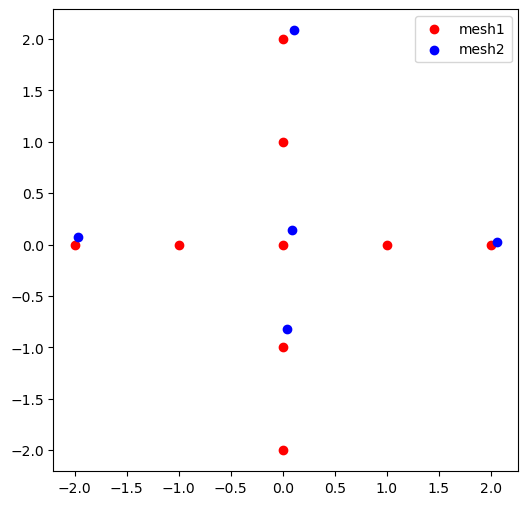

16.191542701950848


NameError: name 'all_nodes' is not defined

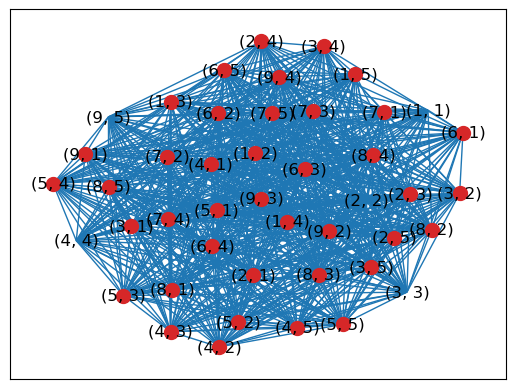

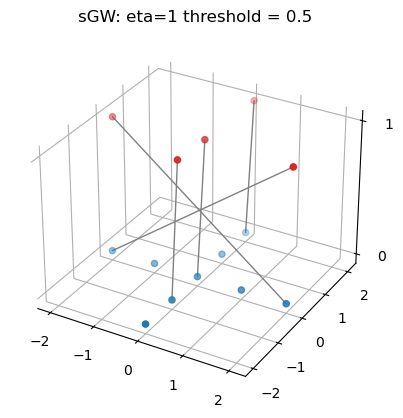

In [1]:
import numpy as np
import matplotlib.pylab as plt
from mpl_toolkits.mplot3d import Axes3D
import scipy as sp
import networkx as nx
import random
from scipy.spatial.distance import cdist
from matplotlib.lines import Line2D

#####################

threshold = 0.5
gamma = 10
eps = 1e-2
eta = 1
verbose = False
nitermax = 40
#####################

random_state=1
np.random.seed(random_state)
#random.seed(random_state)


# Create a mesh of points
mesh1 = np.array([[0, 0], [-2, 0], [2, 0], [0, 2], [0, -2],[1, 0],[-1, 0],[0, 1],[0, -1]])
# mesh1 = mesh1 + np.random.rand(*mesh1.shape) * 3e-1
mesh2 = np.array([[0, 0, 0], [2, 0, 0], [-2, 0, 0], [0, 2, 0], [0, -1, 0]])
mesh2 = mesh2  + 2e-1 * np.random.rand(*mesh2.shape)
# mesh2 = mesh2 + np.random.rand(*mesh2.shape) * 3e-1



plt.figure(figsize=(6, 6))
plt.scatter(mesh1[:, 0], mesh1[:, 1], color='red', label='mesh1')
plt.scatter(mesh2[:, 0], mesh2[:, 1], color='blue', label='mesh2')
plt.legend()
plt.show()


# Compute the distance matrix of the random mesh
C1 = cdist(mesh1, mesh1)
C2 = cdist(mesh2, mesh2)

# P = sgwconv.supervised_gromov_wasserstein_conv(C1, C2, nitermax=20, threshold=100)
######################################################################################
def perform_sOT_log(G, a, b, eps, options):

    niter = options['niter_sOT']
    f     = options['f_init']
    g     = options['g_init']
    M     = options['penalty']

    # Err = np.array([[1, 1]])

    for q in range(niter):   
        f = np.minimum(eps * np.log(a) - eps * np.log(np.sum(np.exp((f[:, None] + g[None, :]  - G) / eps), axis=1)+ 10**-20) + f, M)
        g = np.minimum(eps * np.log(b) - eps * np.log(np.sum(np.exp((f[:, None] + g[None, :]  - G) / eps), axis=0)+ 10**-20) + g, M)

    P = np.exp((f[:, None] + g[None, :] - G) / eps)
    
    return P, f, g

def vertex_with_most_edges(graph):
    degrees = dict(graph.degree())     
    max_degree = max(degrees.values())
    max_degree_vertices = [vertex for vertex, degree in degrees.items() if degree == max_degree]

    return max_degree_vertices, max_degree




n = C1.shape[0]
m = C2.shape[0]

  
#build graph and find an approximation of min vertex covering
G = nx.Graph()
for i in range(n):
    for j in range(m):
        vertex = (i+1, j+1) 
        G.add_node(vertex)

tensor4 = np.zeros((n, m, n, m))

C1_exp = C1[:, None, :, None]
C2_exp = C2[None, :, None, :]
tensor4 = (C1_exp - C2_exp)**2
    
positions = np.where(tensor4 > threshold**2) 
vertex_positions = positions[0] + 1, positions[1] + 1, positions[2] + 1,positions[3] + 1

for i in range(len(positions[0])) :
    first_elements = [arr[i-1] for arr in vertex_positions]
    vertex1 = (first_elements[0],first_elements[1])
    vertex2 = (first_elements[2],first_elements[3])
    G.add_edge(vertex1, vertex2) 
  

tuples_set = set()
B = G.copy()



while B.edges:
    vertices, degree = vertex_with_most_edges(B)
    vertex = random.choice(vertices)
    B.remove_node(vertex)
    tuples_set.add(vertex)

if not B.edges and verbose:
    print("No more edges in the graph.")  
if verbose:
    print(f"Minimum vertex cover algorithm is done, which finds {len(tuples_set)} out of {m * n} entries are 0 in the coupling P!")

nx.draw_networkx(G, nodelist=tuples_set, node_size=100, node_color='tab:red',edge_color='tab:blue', with_labels=True) 

#run sot and update P

a = np.array([1 / n] * n, dtype=float)
aa = a + 1e-1 * np.random.rand(n)
b = np.array([1 / m] * m, dtype=float)
bb = b + 1e-1 * np.random.rand(m)

aa = aa / np.linalg.norm((aa), ord=1)
bb = bb / np.linalg.norm((bb), ord=1)
    
#real convergence value
#eta = eps/(np.sqrt(2)* n * m * min(np.max(a), np.max(b)) * max(np.max(C1)**2,np.max(C2)**2) + eps)

# Get the adjacency matrix as a NumPy array
adj_matrix_np = nx.convert_matrix.to_numpy_array(G)

# Save the adjacency matrix to a text file
np.savetxt("adjacency_matrix_UNbalanced.txt", adj_matrix_np, fmt="%d")

    
P = np.outer(aa, bb) 
f = np.zeros(n)
g = np.zeros(m)
p_values = range(nitermax)
#sgw_values = []

print(max(np.max(C1)**2,np.max(C2)**2))

for p in p_values:
        
    D = np.zeros((n, m)) 
    P_reshaped = P.reshape(1, 1, n, m) 
    D = np.sum(tensor4 * P_reshaped, axis=(-2, -1))
    #sgw = np.sum(D * P)+gamma*(np.sum(a)+np.sum(b)-2*np.sum(P))+eps*np.sum(P * (np.log(P+10**(-20)*np.ones((n,m)))-np.ones((n,m))))
    #sgw_values.append(sgw)
    
    D = 2*eta*D+eps*(eta-1)*np.log(P+10**(-20)*np.ones((n,m)))
                    
    for s, t in tuples_set:
        D[s-1, t-1] = np.inf
        
    options = {
    'niter_sOT': 10**5,
    'f_init': np.zeros(n),
    'g_init': np.zeros(m),
    'penalty': eta*gamma
    }
        
    P,f,g = perform_sOT_log(D, a, b, eps, options)

######################################################################################
#######################################################################################

def plot_mapping(P,X_1,X_2, thresh=None, linewidth=1):

    fig = plt.figure()
    
    ax = plt.axes(projection='3d') 
    ax.scatter3D(X_1[:,0], X_1[:,1], 0, c='tab:blue')
    ax.scatter3D(X_2[:,0], X_2[:,1], 1, c='tab:red')
    ax.set_title('sGW: eta=' + str(eta) + ' threshold = ' +str(threshold))
    
    for i in range(P.shape[1]):
        if P[:,i].sum() < thresh: continue
        j = np.argmax(P[:,i])
        ax.plot3D([X_1[j,0], X_2[i,0]],[X_1[j,1], X_2[i,1]],[0,1],c='gray', linewidth=linewidth)
    ax.xaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
    ax.yaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
    ax.zaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
    ax.set_zticks([0, 1])
    
plot_mapping(P, mesh1, mesh2, thresh=0.00000001)
plt.savefig('./1108_graph23.pdf') 

# Assume G and tuples_set are already defined

# Get the position of the nodes using a layout algorithm
pos = nx.spring_layout(G)

# Initialize a color map with 'blue' for all nodes and 'tab:orange' for nodes in tuples_set
color_map = ['tab:purple' if node not in tuples_set else 'tab:brown' for node in all_nodes]

# Draw the graph
nx.draw_networkx_nodes(G, pos, node_size=100, node_color=color_map)
nx.draw_networkx_edges(G, pos, edge_color='grey', width=0.4, alpha=0.3)
nx.draw_networkx_labels(G, pos)

# Create a legend
legend_elements = [
    Line2D([0], [0], marker='o', color='w', label='MVC', markersize=17,markerfacecolor='tab:brown'),
    Line2D([0], [0], marker='o', color='w', label='Others', markersize=17, markerfacecolor='tab:purple'),
]

# Place the legend on the plot
plt.legend(handles=legend_elements, loc='best', fontsize=15)

# Show the plot with the legend
plt.savefig('mvc_2.png')
